# Предсказание числа дней занятости аренды недвижимости
**Информация:**

* name: название объекта

* _id: уникальный идентификатор

* host_name: имя владельца или хоста, который предоставляет жилье

* location_cluster: кластеризация местоположений (например, группировка объектов по районам или зонам)

* location: описание местоположения объекта

* lat, lon: широта и долгота местоположения объекта

* type_house: тип жилья

* sum: общая стоимость аренды или сумма за определенный период

* min_days: минимальное количество дней для бронирования объекта

* amt_reviews: количество отзывов, оставленных для данного объекта

* last_dt: дата последнего отзыва или последнего бронирования

* avg_reviews: средний рейтинг или среднее количество отзывов за определенный период

* total_host: общее количество объектов, принадлежащих одному хосту

* target: целевая переменная

**Размеры:**
train (36671, 15), test (12224, 14)

Соревнование на Kaggle: https://www.kaggle.com/competitions/teta-ml-2-2025

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from scipy import stats
from scipy.stats import ks_2samp
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [2]:
!gdown -- 1_2ilM6dfqrxo6DWzCjDrGlHzGN8smqNg
test = pd.read_csv('test.csv')

Downloading...
From: https://drive.google.com/uc?id=1_2ilM6dfqrxo6DWzCjDrGlHzGN8smqNg
To: /content/test.csv
100% 1.63M/1.63M [00:00<00:00, 75.5MB/s]


In [3]:
!gdown -- 1DF6y0sKM8UGA3ZhSyNIkYcE4lAsNjdrI
train = pd.read_csv('train.csv')
train.head(2)

Downloading...
From: https://drive.google.com/uc?id=1DF6y0sKM8UGA3ZhSyNIkYcE4lAsNjdrI
To: /content/train.csv
100% 4.99M/4.99M [00:00<00:00, 40.9MB/s]


,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2019-07-07,2.88,1,334
1,"Come see Brooklyn, New York",13617520,Howard T.,Brooklyn,Clinton Hill,40.69172,-73.96934,Shared room,40,5,8,2015-02-25,0.13,1,0


## Анализ и обработка данных

#### Feature engineering

##### last_dt: дата последнего отзыва или последнего бронирования

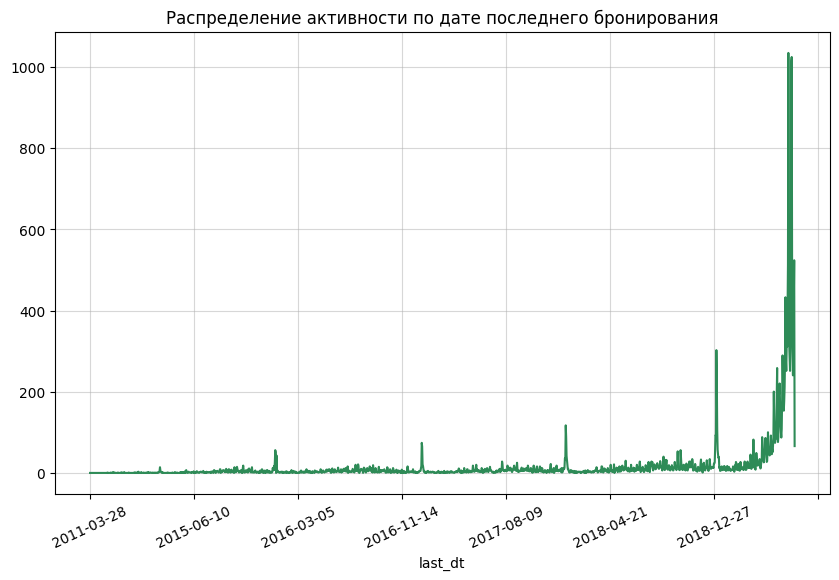


Пропуски в train: 7502, в test: 2550


In [4]:
# распределение активности по дате последнего бронирования
plt.figure(figsize=(10, 6))
train[~train['last_dt'].isna()]['last_dt'].value_counts().sort_index().plot(color = 'seagreen')
plt.title("Распределение активности по дате последнего бронирования")
plt.grid(alpha=0.5)
plt.xticks(rotation=25)
plt.show()

# колличесвто пропусков
train_null = train['last_dt'].isnull().sum()
test_null = test['last_dt'].isnull().sum()
print(f"\nПропуски в train: {train_null}, в test: {test_null}")

**Результаты:**
1. На графике видим, что есть старые объявления с последней активностью в 2011-2018 годах. Но для большинства объявлений послденяя активность была в 2019 году.
2. Найдено много пропусков для показателя 'last_dt', которые необходимо заполнить.

In [5]:
# заполняем пропуски используя host_name, а оставшиеся пропуски по location_cluster
unite = pd.concat([train, test], axis=0)
unite['last_dt'] = pd.to_datetime(unite['last_dt'])

unite['last_dt'] = unite.groupby('host_name')['last_dt'].transform(
    lambda x: x.fillna(pd.to_datetime(x.dropna().max()))
)

unite['last_dt'] = unite.groupby('location_cluster')['last_dt'].transform(
    lambda x: x.fillna(pd.to_datetime(x.dropna().max()))
)

train = unite.iloc[:len(train)].copy()
test = unite.iloc[len(train):].drop(columns=['target']).copy()

In [6]:
# базовая дата - максимальная в данных
reference_date = pd.to_datetime(unite['last_dt']).max()

# считаем разницу в днях
train['days_since_last_dt'] = (reference_date - pd.to_datetime(train['last_dt'])).dt.days
test['days_since_last_dt'] = (reference_date - pd.to_datetime(test['last_dt'])).dt.days

##### Числовые показатели

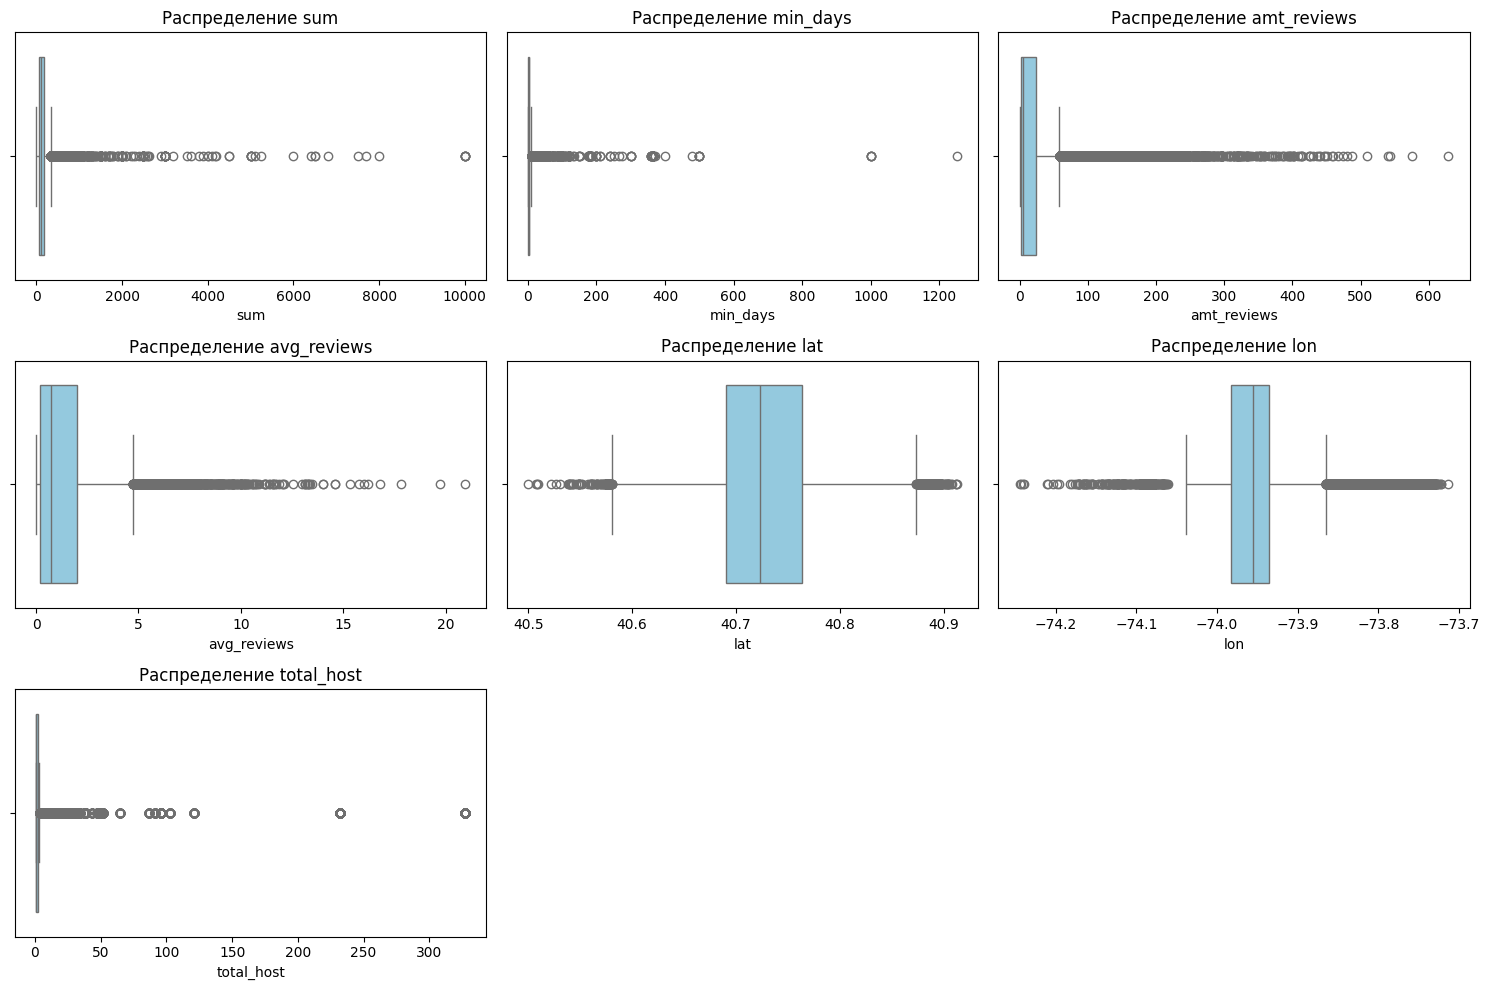

Статистики для числовых признаков:
                sum      min_days   amt_reviews   avg_reviews           lat  \
count  36671.000000  36671.000000  36671.000000  29169.000000  36671.000000   
mean     152.142292      7.053176     23.433667      1.365601     40.729080   
std      239.107973     21.539569     44.703590      1.643966      0.054671   
min        0.000000      1.000000      0.000000      0.010000     40.499790   
25%       69.000000      1.000000      1.000000      0.190000     40.690090   
50%      106.000000      3.000000      5.000000      0.720000     40.723150   
75%      175.000000      5.000000     24.000000      2.010000     40.763260   
max    10000.000000   1250.000000    629.000000     20.940000     40.912340   

                lon    total_host  
count  36671.000000  36671.000000  
mean     -73.951958      7.047694  
std        0.046201     32.595427  
min      -74.244420      1.000000  
25%      -73.982970      1.000000  
50%      -73.955560      1.000000  
7

In [7]:
numeric_features = ["sum", "min_days", "amt_reviews", "avg_reviews", "lat", "lon", "total_host"]

# Построение boxplot для каждого числового признака
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train[feature], color='skyblue')
    plt.title(f"Распределение {feature}")
    plt.tight_layout()
plt.show()

# Описательная статистика
print("Статистики для числовых признаков:")
print(train[numeric_features].describe())

**Результаты:**
1. sum: очень высокая дисперсия, сильная правосторонняя асимметрия. Попробуем логарифмирование для нормализации распределения и уменьшения влияния выбросов.

2. min_days: аномальные значения (максимум 1250 дней), сильная асимметрия. Обрежем значения до 365 дней.

4. amt_reviews: правосторонняя асимметрия (большинство объектов имеют мало отзывов). Попробуем логарифмирование для нормализации распределения и уменьшения влияния выбросов.

5. avg_reviews: аномальные значения (максимум 20.94 при стандартной шкале 0-5), пропуски. Так как это значения не только рейтинга, но и колличества отзывов оценить наличие выбросов затруднительно. На графике видим, что основные значения находятся в диапозоне 0-5, что ближе к шкале оценок.

6. lat и lon: координаты соответствуют Нью-Йорку (широта ~40.7, долгота ~-74),выбросов нет.

7. total_host: сильная асимметрия (максимум 327, при 75% перцентиле 2). Попробуем логарифмирование для нормализации распределения и уменьшения влияния выбросов.




In [8]:
# ограничение значений
lower_limit = train['sum'].quantile(0.05)
upper_limit = train['sum'].quantile(0.95)
train['sum'] = np.clip(train['sum'], a_min=lower_limit, a_max=upper_limit)

lower_limit = test['sum'].quantile(0.05)
upper_limit = test['sum'].quantile(0.95)
test['sum'] = np.clip(test['sum'], a_min=lower_limit, a_max=upper_limit)

# логарифмирование
train['sum'] = np.log1p(train['sum'])
test['sum'] = np.log1p(test['sum'])

In [9]:
# ограничение значений
train['min_days'] = np.clip(train['min_days'], a_min=1, a_max=365)
test['min_days'] = np.clip(test['min_days'], a_min=1, a_max=365)

# # сделаем бинарный признак
# train['long_term'] = (train['min_days'] > 5).astype(int)
# test['long_term'] = (test['min_days'] > 5).astype(int)

In [10]:
# логарифмирование
train['amt_reviews'] = np.log1p(train['amt_reviews'])
test['amt_reviews'] = np.log1p(test['amt_reviews'])

In [11]:
# ограничение значений
train['avg_reviews'] = np.clip(train['avg_reviews'], a_min=0, a_max=5)
test['avg_reviews'] = np.clip(test['avg_reviews'], a_min=0, a_max=5)

# заполнение пропусков
train['avg_reviews'] = train['avg_reviews'].fillna(train['avg_reviews'].median())
test['avg_reviews'] = test['avg_reviews'].fillna(test['avg_reviews'].median())

In [12]:
# # обрезка по точным координатам
# ny_bbox = {
#     "lat_min": 40.5,
#     "lat_max": 40.9,
#     "lon_min": -74.3,
#     "lon_max": -73.7
# }
# mask = (
#     train["lat"].between(ny_bbox["lat_min"], ny_bbox["lat_max"]) &
#     train["lon"].between(ny_bbox["lon_min"], ny_bbox["lon_max"])
# )
# train = train[mask]

# mask = (
#     test["lat"].between(ny_bbox["lat_min"], ny_bbox["lat_max"]) &
#     test["lon"].between(ny_bbox["lon_min"], ny_bbox["lon_max"])
# )
# test = test[mask]

# # кластеризация координат для выделения районов
# coords_1 = train[['lat', 'lon']].values
# coords_2 = test[['lat', 'lon']].values

# coords_radians_1 = np.radians(coords_1)
# coords_radians_2 = np.radians(coords_2)
# eps_km = 0.5                        # радиус поиска соседей в километрах
# min_samples = 10                    # минимальное количество точек для формирования кластера
# earth_radius_km = 6371.0            # радиус Земли
# epsilon = eps_km / earth_radius_km  # epsilon в радианах

# dbscan = DBSCAN(
#     eps=epsilon,
#     min_samples=min_samples,
#     metric='haversine',
#     algorithm='ball_tree'
# )

# train['district_cluster'] = dbscan.fit_predict(coords_radians_1)
# test['district_cluster'] = dbscan.fit_predict(coords_radians_2)

In [13]:
# логарифмирование
train['total_host'] = np.log1p(train['total_host'])
test['total_host'] = np.log1p(test['total_host'])

# # сделаем категоризацию: 1 (1 объявление), 2-5 (малые хосты), 5+ (крупные хосты).
# train['host_category'] = pd.cut(
#     train['total_host'],
#     bins=[0, 1, 5, np.inf],
#     labels=['1', '2-5', '5+'],
#     right=True
# )

#### Coding and emissions  

In [14]:
# удаляем ненужные столбцы
drop_columns = ['host_name', '_id', 'name', 'last_dt']
train = train.drop(drop_columns, axis=1)
test = test.drop(drop_columns, axis=1)
feature_names = train.drop('target', axis=1).columns.tolist()

# разделение с выборкой out of sample
X_train, X_test, y_train, y_test = train_test_split(
    train.drop('target', axis=1),
    train['target'],
    test_size=0.33,
    random_state=42,
    stratify=train['target']
)

In [15]:
# кодирование категориальных признаков
cat_columns = ['location_cluster', 'location', 'type_house']
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', oe, cat_columns)
    ], remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

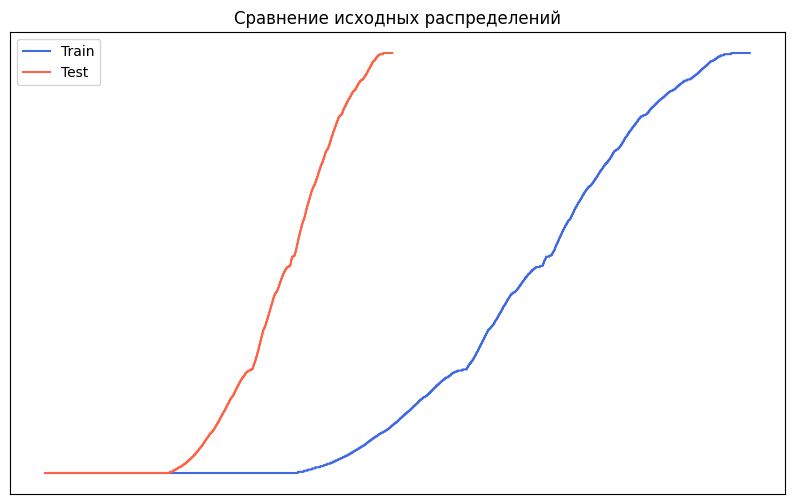


Тест Колмогорова-Смирнова p-value: 1.0


In [16]:
# сравниваем распределния исходных данных
plt.figure(figsize=(10, 6))
plt.plot(sorted(y_train), label='Train', color='royalblue')
plt.plot(sorted(y_test), label='Test', color='tomato')
plt.legend()
plt.title('Сравнение исходных распределений')
plt.yticks([])
plt.xticks([])
plt.show()

# тест Колмогорова-Смирнова
ks_statistic, p_value = ks_2samp(y_train, y_test)
print(f"\nТест Колмогорова-Смирнова p-value: {p_value}")

**Результаты:**
1. На графике видим схожие распределения, но для сравнения выборок разного размера необходимо нормировать выборки.

2. Тест Колмогорова-Смирнова: p-value > 0.05, следовательно различия распределений незначимы.

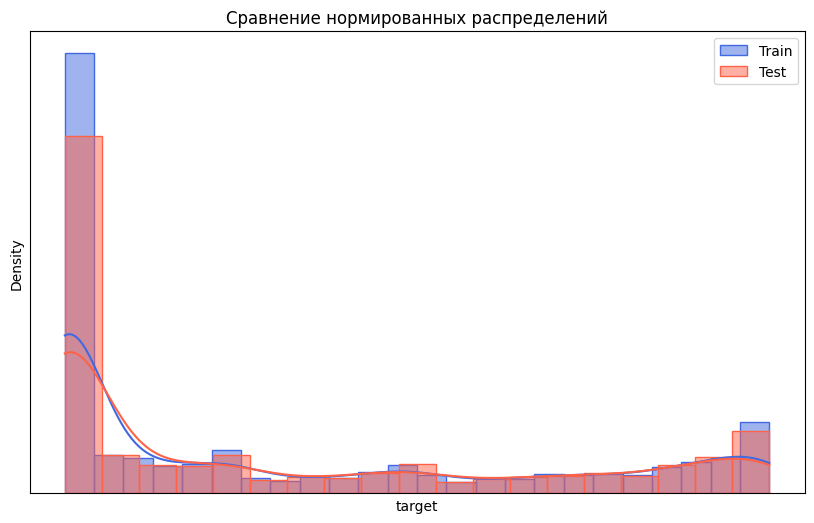

In [17]:
# строим нормированные гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, stat="density", color="royalblue", label="Train", edgecolor='royalblue')
sns.histplot(y_test, kde=True, stat="density", color="tomato", label="Test", edgecolor='tomato')
plt.title("Сравнение нормированных распределений")
plt.legend()
plt.yticks([])
plt.xticks([])
plt.show()

**Описание графика:** График с нормированными гистограммами подтверждает результаты теста Колмогорова-Смирнова о незначительном различии распределений.


## RandomForestRegressor

#### Подбор гиперпараметров

In [ ]:
# настройка гиперпараметров
param_dist = {
    'n_estimators': np.arange(100, 600, 100),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['sqrt', 0.8, 'log2']
}

# настройка рандомизированного поиска
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1)
random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший MSE:", -random_search.best_score_)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры: {'n_estimators': np.int64(500), 'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(1), 'max_features': 'log2', 'max_depth': np.int64(20)}
Лучший MSE: 10341.141669599388


#### Кросс-валидация и обучение модели

In [25]:
best_params = {
    'n_estimators': 500,
    'max_depth': 20,
    'min_samples_split': 6,
    'min_samples_leaf': 1,
    'max_features': 'log2'
}

# RandomForestRegressor
model = RandomForestRegressor(**best_params, random_state=42)

# кросс-валидация
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
for i, mse in enumerate(-scores, 1):
    print(f'Fold {i} MSE: {mse}')
print("\nAverage CV MSE:", -scores.mean())

# обучение на полном тренировочном наборе
model_full = RandomForestRegressor(**best_params, random_state=42)
model_full.fit(X_train, y_train)

test_pred = model_full.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
print(f'\nTest MSE: {test_mse}')

Fold 1 MSE: 10485.173529205751
Fold 2 MSE: 10434.528416051915
Fold 3 MSE: 10221.309874167737
Fold 4 MSE: 10318.445947534074
Fold 5 MSE: 10246.25058103747

Average CV MSE: 10341.141669599388

Test MSE: 10192.378003148648


**Результаты кросс-валидации:**

1. Тестовая MSE ниже средней MSE на кросс-валидации, следовательно модель не переобучилась — она хорошо обобщает данные.

2. Разница между самым высоким и самым низким MSE по фолдам составила ~2.6%, что незначительно и указывает на однородность данных и отсутствие сильной зависимости от разбиения. Модель работает стабильно.

In [26]:
# параметры для дополнительной оценки
variance_y = np.var(y_train)
print(f"Variance of y: {variance_y}")
test_mae = mean_absolute_error(y_test, test_pred)
print(f"Test MAE: {test_mae}")
r2 = r2_score(y_test, test_pred)
print(f"R²: {r2}")
# очень плохо по R^2, 41% данных описывает модель

Variance of y: 17327.560930340514
Test MAE: 77.18403412135159
R²: 0.4103516363034202


<ipython-input-32-5b1ad3076875>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='tomato', lw=2)


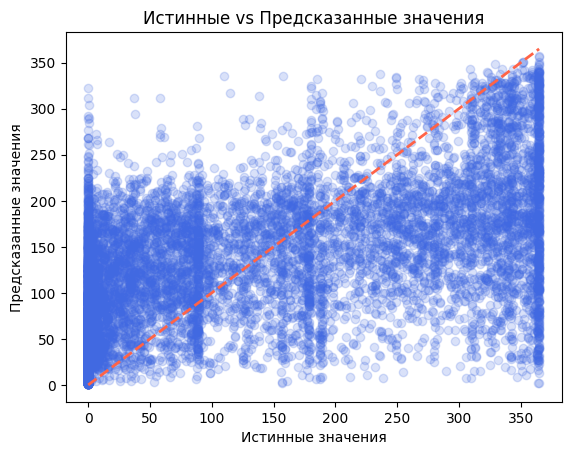

In [32]:
# график истинных vs предсказанных значений
plt.scatter(y_test, test_pred, alpha=0.2, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='tomato', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные значения')
plt.show()

**Описание графика:** точки разбросаны очень сильно, предсказания далеки от реальных значений.

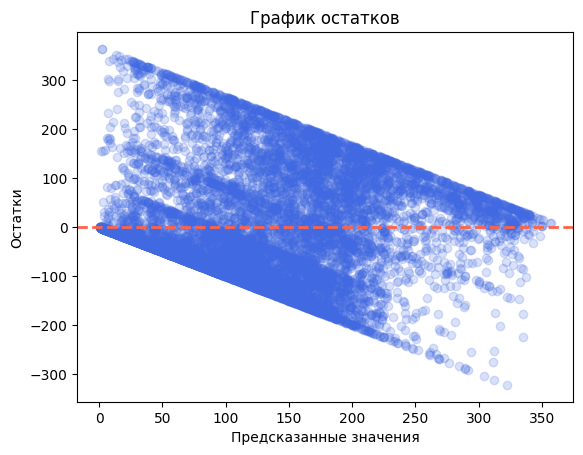

In [33]:
# График остатков
residuals = y_test - test_pred
plt.scatter(test_pred, residuals, alpha=0.2, color='royalblue')
plt.axhline(y=0, color='tomato', linestyle='--', lw=2)
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

**Описание графика:** убывающая тенденция в остатках показывет нарушение предположения о их случайности. Модель завышает значения для малых y и занижает для больших y.

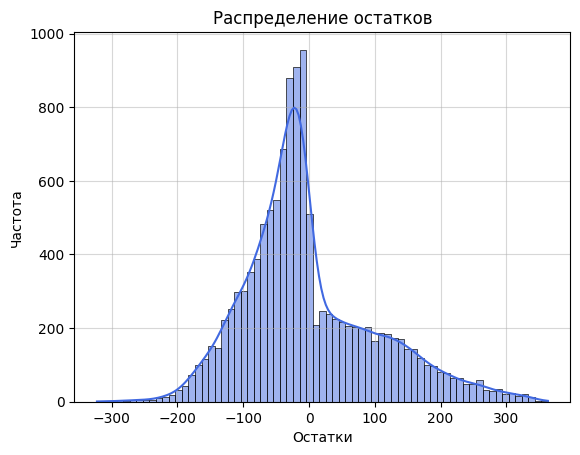

In [29]:
# Распределение остатков
sns.histplot(residuals, kde=True, color='royalblue')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.grid(alpha=0.5)
plt.show()

**Описание графика:** остатки распределены асимметрично, значит модель систематически занижает или завышает предсказания. Пик слева от нуля (отрицательные остатки), значит много случаев, когда истинные значения меньше предсказанных. А резкий спад справа говорит о том, что положительные остатки встречаются реже. Есть общее смещение модели в сторону завышения предсказаний.

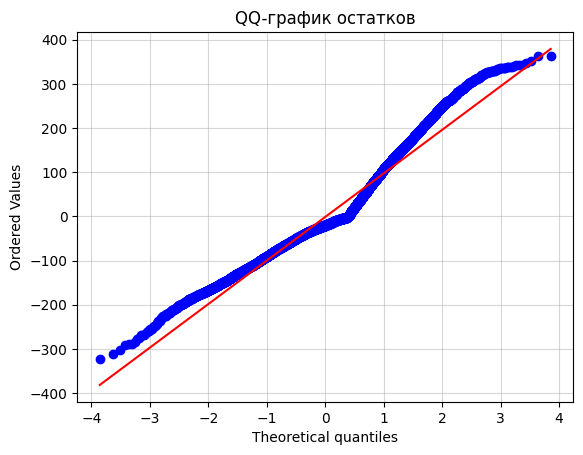

In [30]:
# QQ-график
residuals = y_test - test_pred
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ-график остатков')
plt.grid(alpha=0.5)
plt.show()

**Описание графика:** отклонения остатков от нормального распределения в хвостах и около нуля. Возможно, модель слишком уверена в некоторых предсказаниях...



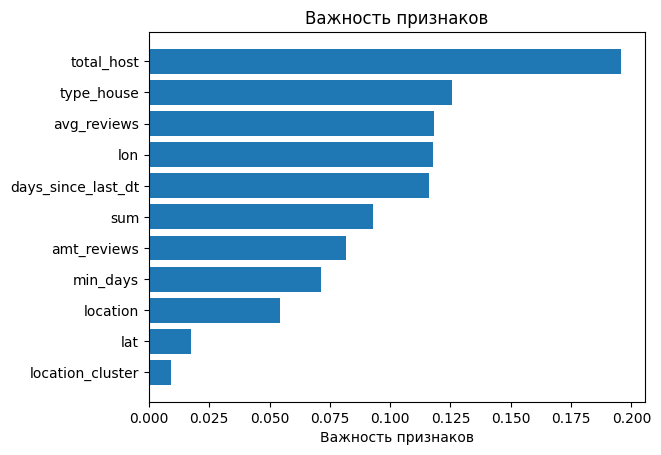

In [23]:
# Важность признаков
importances = model_full.feature_importances_
sorted_idx = importances.argsort()

plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])  # Используем feature_names
plt.xlabel('Важность признаков')
plt.title('Важность признаков')
plt.show()

**Описание графика:** Цель: Определить, какие признаки наиболее влияют на предсказания.

In [34]:
# финальное обучение на всех данных
X_full = train.drop('target', axis=1)
y_full = train['target']

# кодирование категориальных признаков
cat_columns = ['location_cluster', 'location', 'type_house']

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', oe, cat_columns)
    ], remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X_full)

model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_processed, y_full)

X_test_processed = preprocessor.transform(test)
test_predictions = model.predict(X_test_processed)

# Создаем файл сабмита
sample_submission = pd.DataFrame({
    'index': test.index,
    'prediction': test_predictions
})
sample_submission.to_csv('sample_submission.csv', index=False)



---


**intro — описание финального решения:**
1.  **Обработка данных.** Для признака last_dt заполнены пропуски и добавлено количество дней от последнего бронирования. Для sum, min_days и avg_reviews ограничены минимальное и максимальное значения, для sum, amt_reviews и total_host и применено логарифмирование. Для avg_reviews заполнены пропуски.  Категориальные признаки закодированы с помощью OrdinalEncoder.

2. **Алгоритм.** RandomForestRegressor строит множество деревьев решений, каждое из которых обучается на случайной подвыборке данных (с повторениями — бутстрэп). Устойчив к переобучению за счет усреднения предсказаний множества деревьев и случайного выбора данных. Независимое параллельное обучение деревье, что сильно ускоряет процесс.

3. **Особенности при обучении.** Настройка гиперпараметров: подбор оптимальных колличества деревьев и их глубины, параметры минимального числа образцов в листе и для разделения узлов. Сделан рандомный перебор сетки параметров для 50 итераций.

4. **Валидация алгоритма.** Результаты кросс-валидации показали работоспособность модели, результаты стабильны, а расхождение между кросс-валидацией и тестом незначительно. Графики показали печальные результаты, предсказания модели далеки от реальных значений, остатки распределены не нормально, в них етсь зависимость.


---


**outro — описание вариантов по дальнейшему улучшению итогового подхода:**

1. **Улучшить feature engineering:** применённые споосбы не улучшили работу модели, а некоторые даже ухудшили (поэтому их закоментила). Возможно для min_days нужно делать не бинарный признак, а более сложную классификацию. total_host самый важный показатель, его категоризация не улучшила модель, что странно.

2. **Ансамблирование:** например, объединить RandomForestRegressor с XGBRegressor и LGBMRegressor: `estimators = [ ('rf', RandomForestRegressor(**best_params)), ('xgb', XGBRegressor()), ('lgbm', LGBMRegressor())]`.

3. **Генерация признаков:** добавьте полиномиальные и взаимодейственные признаки: `poly = PolynomialFeatures(degree=2, interaction_only=True)`

*P.S. Так как это мой второй опыт в ML, не могу понять причину таких плохих результатов по остаткам, при этом хорошие результаты кросс-валидации.*


In [36]:
%%shell
jupyter nbconvert --to html /content/Competition_2 (2).ipynb

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `jupyter nbconvert --to html /content/Competition_2 (2).ipynb'


CalledProcessError: Command 'jupyter nbconvert --to html /content/Competition_2 (2).ipynb
' returned non-zero exit status 2.